<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/9_1_simulate_a_Gabor_Patch_identification_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Gabor patches and devide them into train and validation sets. The validation set contains the easiest examples, which are close to 45 degrees

## function credit: [Sanjeev](https://www.bcbl.eu/people/staff/sanjeev-nara/)

In [1]:
"""
Created on Fri Nov 22 14:26:17 2019

@author: nmei

this script is to generate folders of gabor instances.
The angles ranges from -89 (left) to 89 (right), while zero is not included,
those angles that are close to +/-45 are used for validation

"""

import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from joblib import Parallel,delayed
import gc
gc.collect()

# number of pixels per axis
imSize = 128
# 50 lambda values for generating the gabors
lamdas = np.linspace(4,32,20)
# 300 degrees between -89 to 89 degree
thetaRads = np.linspace(-89,89,20)
# plot of the generated gabors
figure_dir = 'data/gabors/small'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

def generator(lamda = 4, thetaRad_base = 45,figure_dir = 'data/gabors'):
    """
    Inputs
    -------------
    lamda: float, better be in range between 4 and 32
    thetaRad_base:float, base value of theta, in degrees
    figure_dir: string, mother directory of the gabors, will be divided into train
            and validation
    """
    if (np.abs(np.abs(thetaRad_base) - 45) < 5): # make easy cases the validation set
        folder = 'validation'
    else:
        folder = 'train'
    # identify left and right based on the theta base values
    if thetaRad_base < 0:
        sub_folder = 'left'
    else:
        sub_folder = 'right'
    # generate the file name based on the parameteres
    name = f'{lamda_}_{thetaRad_base}_{sub_folder}.jpg'
    saving_name = os.path.join(figure_dir,folder,sub_folder,name)
    if not os.path.exists(os.path.join(figure_dir,folder,sub_folder)):
        os.makedirs(os.path.join(figure_dir,folder,sub_folder))
    # convert degree to pi-based
    thetaRad = thetaRad_base * np.pi / 180
    # Sanjeev's algorithm
    X       = np.arange(imSize)
    X0      = (X / imSize) - .5
    freq    = imSize / lamda_
    Xf      = X0 * freq * 2 * np.pi
    sinX    = np.sin(Xf)
    Xm,Ym   = np.meshgrid(X0,X0)
    Xt      = Xm * np.cos(thetaRad)
    Yt      = Ym * np.sin(thetaRad)
    XYt     = Xt + Yt
    XYf     = XYt * freq * 2 * np.pi

    grating = np.sin(XYf)

    s       = 0.075
    w       = np.exp(-(0.3 * ((Xm**2) + (Ym**2)) / (2 * s**2))) * 2
    w[w > 1]= 1
    gabor   = ((grating - 0.5) * w) + 0.5

    plt.close('all')
    fig,ax = plt.subplots(figsize = (6,6))
    ax.imshow(gabor,cmap = plt.cm.gray)
    ax.axis('off')
    plt.close('all')
    fig.savefig(saving_name,dpi = 400,bbox_inches = 'tight')
    gc.collect() # delete memory garbages

for lamda_ in lamdas:
    # let's parallelize the for-loop
    Parallel(n_jobs = -1,verbose = 1)(delayed(generator)(**{
                    'lamda':lamda_,
                    'thetaRad_base':thetaRad_base,
                    'figure_dir':figure_dir}) for thetaRad_base in thetaRads)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20

# Train a convolutional neural network to perform the idenfication task by training it with hard examples and validating with easy examples

## update your tensorflow

In [0]:
#!pip install --upgrade tensorflow

## many imports

In [3]:
import numpy      as np
import pandas     as pd
import tensorflow as tf

from tensorflow.keras                           import applications,layers,models,optimizers,losses,regularizers
from tensorflow.keras.preprocessing.image       import ImageDataGenerator,random_brightness,load_img,img_to_array

from sklearn.metrics                            import roc_auc_score
from sklearn.utils                              import shuffle

from PIL                                        import Image, ImageEnhance
from functools                                  import partial
import os
from matplotlib                                 import pyplot as plt
from tqdm                                       import tqdm

from joblib                                     import Parallel,delayed
import gc
gc.collect()

22

In [4]:
tf.__version__

'2.1.0'

## some "hyperparameters" of the identification task

In [0]:
working_dir         = 'data/gabors/small'
figure_dir          = 'figures/gabors_small'
batch_size          = 16
image_resize        = 128
drop_rate           = 0.25
model_name          = 'VGG19_small'
model_pretrained    = applications.VGG19
preprocess_input    = applications.vgg19.preprocess_input
model_dir           = ''
patience            = 3
loss_func           = losses.binary_crossentropy
class_mode          = 'categorical'
noise_upper         = 0.75
bright_lower        = 0.05
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## a preprocessing function to control the noise level and brightness of the images that fed to the convolutional neural network model

In [0]:
def process_func(xx,noise_level = 0., brightness_level = 1.,):
    x = xx.copy()
    row,col,ch = x.shape
    x /= 255.
    mean = 0
    sigma = noise_level*0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch)).reshape(row,col,ch)
    noise_x = x + gauss
    noise_x *= 255.
    back_to_image = Image.fromarray(np.uint8(noise_x))
    #back_to_image = back_to_image.convert('L')
    contrast = ImageEnhance.Contrast(back_to_image)
    contrast = contrast.enhance(brightness_level) # set FACTOR > 1 to enhance contrast, < 1 to decrease
    contrast = preprocess_input(np.array(contrast))
    return contrast
def process_func_visualization(xx,noise_level = 0., brightness_level = 1.,):
    x = xx.copy()
    row,col,ch = x.shape
    x /= 255.
    mean = 0
    sigma = noise_level*0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch)).reshape(row,col,ch)
    noise_x = x + gauss
    noise_x *= 255.
    back_to_image = Image.fromarray(np.uint8(noise_x))
    #back_to_image = back_to_image.convert('L')
    contrast = ImageEnhance.Contrast(back_to_image)
    contrast = contrast.enhance(brightness_level) # set FACTOR > 1 to enhance contrast, < 1 to decrease
    #contrast = preprocess_input(np.array(contrast)) <- comment this out for visualization
    return contrast

## define image generator flow and I still have to write lots of codes for customized training -- because we need to train the network to have some "ideal" response to stimuli:

1. output 2 differe probabilities and one is higher than the other when the signal is present
2. output 2 similar probabilities that are close to 0.5 when the signal is absent

In [7]:
gen             = ImageDataGenerator(
                                     preprocessing_function = process_func,
                                     )
gen_train       = gen.flow_from_directory(os.path.join(working_dir,'train'), # train
                                          target_size       = (image_resize,image_resize),  # resize the image
                                          batch_size        = 1,                   # batch size
                                          class_mode        = class_mode,                # get the labels from the folders
                                          shuffle           = False,                         # shuffle for different epochs
                                          seed              = 12345,                        # replication purpose
                                          )
gen_valid       = gen.flow_from_directory(os.path.join(working_dir,'validation'), # validate
                                           target_size      = (image_resize,image_resize),  # resize the image
                                           batch_size       = 1,                   # batch size
                                           class_mode       = class_mode,                # get the labels from the folders
                                           shuffle          = False,                         # shuffle for different epochs
                                           seed             = 12345,                        # replication purpose
                                           )

X_train,y_train = [],[]
for ii,(X_,y_) in enumerate(gen_train):
    X_train.append(X_)
    y_train.append(y_[0])
    if ii >= gen_train.n - 1:
        break
X_valid,y_valid = [],[]
for ii,(X_,y_) in enumerate(gen_valid):
    X_valid.append(X_)
    y_valid.append(y_[0])
    if ii >= gen_valid.n - 1:
        break
process_function = partial(process_func,noise_level = noise_upper, brightness_level = 1.)
gen             = ImageDataGenerator(preprocessing_function = process_function,)
gen_train       = gen.flow_from_directory(os.path.join(working_dir,'train'), # train
                                          target_size       = (image_resize,image_resize),  # resize the image
                                          batch_size        = 1,                   # batch size
                                          class_mode        = class_mode,                # get the labels from the folders
                                          shuffle           = False,                         # shuffle for different epochs
                                          seed              = 12345,                        # replication purpose
                                          )
gen_valid       = gen.flow_from_directory(os.path.join(working_dir,'validation'), # validate
                                           target_size      = (image_resize,image_resize),  # resize the image
                                           batch_size       = 1,                   # batch size
                                           class_mode       = class_mode,                # get the labels from the folders
                                           shuffle          = False,                         # shuffle for different epochs
                                           seed             = 12345,                        # replication purpose
                                           )
for ii,(X_,_) in enumerate(gen_train):
    X_train.append(X_)
    y_train.append([0.5,0.5])
    if ii >= gen_train.n - 1:
        break
for ii,(X_,_) in enumerate(gen_valid):
    X_valid.append(X_)
    y_valid.append([0.5,0.5])
    if ii >= gen_valid.n - 1:
        break
process_function = partial(process_func,noise_level = 0., brightness_level = bright_lower)
gen             = ImageDataGenerator(preprocessing_function = process_function,)
gen_train       = gen.flow_from_directory(os.path.join(working_dir,'train'), # train
                                          target_size       = (image_resize,image_resize),  # resize the image
                                          batch_size        = 1,                   # batch size
                                          class_mode        = class_mode,                # get the labels from the folders
                                          shuffle           = False,                         # shuffle for different epochs
                                          seed              = 12345,                        # replication purpose
                                          )
gen_valid       = gen.flow_from_directory(os.path.join(working_dir,'validation'), # validate
                                           target_size      = (image_resize,image_resize),  # resize the image
                                           batch_size       = 1,                   # batch size
                                           class_mode       = class_mode,                # get the labels from the folders
                                           shuffle          = False,                         # shuffle for different epochs
                                           seed             = 12345,                        # replication purpose
                                           )
for ii,(X_,_) in enumerate(gen_train):
    X_train.append(X_)
    y_train.append([0.5,0.5])
    if ii >= gen_train.n - 1:
        break
for ii,(X_,_) in enumerate(gen_valid):
    X_valid.append(X_)
    y_valid.append([0.5,0.5])
    if ii >= gen_valid.n - 1:
        break

Found 360 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [0]:
X_train = np.concatenate(X_train)
X_valid = np.concatenate(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)
X_train,y_train = shuffle(X_train,y_train)
X_valid,y_valid = shuffle(X_valid,y_valid)

## helper function

In [0]:
# the most important helper function: early stopping and model saving
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    from tensorflow.keras.callbacks             import ModelCheckpoint,EarlyStopping
    """
    Make call back function lists for the keras models

    Inputs
    -------------------------
    model_name: directory of where we want to save the model and its name
    monitor:    the criterion we used for saving or stopping the model
    mode:       min --> lower the better, max --> higher the better
    verboser:   printout the monitoring messages
    min_delta:  minimum change for early stopping
    patience:   temporal windows of the minimum change monitoring
    frequency:  temporal window steps of the minimum change monitoring

    Return
    --------------------------
    CheckPoint:     saving the best model
    EarlyStopping:  early stoppi
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 verbose          = verbose,# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose,
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]

## the training process

### transfer learning VGG19

1. a hidden layer with 300 neurons
2. control for the magnitudes of weights (L2 penalty)

In [10]:
tf.keras.backend.clear_session()

# after loading the model from the pretrained repository, freeze the parameters
print(f'\nloading {model_name} ...\n')
np.random.seed(12345)
tf.random.set_seed(12345)
model_loaded    = model_pretrained(weights      = 'imagenet',
                                   include_top  = False,
                                   input_shape  = (image_resize,image_resize,3),
                                   pooling      = 'max',
                                   )
for layer in model_loaded.layers:
    layer.trainable = False

# now, adding 2 more layers: CNN --> 300 --> discriminative prediction
fine_tune_model = model_loaded.output
#fine_tune_model = layers.Dropout(drop_rate,name = 'feature_drop')(fine_tune_model)
fine_tune_model = layers.Dense(300,
                               activation                       = tf.keras.activations.selu, # SOTA activation function
                               kernel_initializer               = 'lecun_normal', # seggested in documentation
                               kernel_regularizer               = regularizers.l2(),
#                               activity_regularizer             = regularizers.l1(),
#                               use_bias                         = False,                       
                               name                             = 'feature'
                               )(fine_tune_model)
#fine_tune_model = layers.Dropout(drop_rate,name = 'predict_drop')(fine_tune_model)
fine_tune_model = layers.Dense(2,
                               activation                       = 'softmax',#'sigmoid',
#                               use_bias                         = False,
                               kernel_regularizer               = regularizers.l2(),
#                               activity_regularizer             = regularizers.l1(),
                               name                             = 'predict'
                               )(fine_tune_model)
clf             = models.Model(model_loaded.inputs,fine_tune_model)
print(clf.summary())
# compile the model with an optimizer, a loss function
clf.compile(optimizers.Adam(lr = 1e-4,),
            loss_func,
            metrics = [tf.keras.metrics.AUC()])
saving_model_name   = os.path.join(model_dir,f'{model_name}.h5')
callbacks           = make_CallBackList(saving_model_name,
                                        monitor                 = 'val_{}'.format(clf.metrics_names[-2]),
                                        mode                    = 'min',
                                        verbose                 = 0,
                                        min_delta               = 1e-4,
                                        patience                = patience,
                                        frequency               = 1)
print(f'training {model_name} ...')

clf.fit(X_train,y_train,
        epochs                                      = 1000, # arbitrary choice
        validation_data                             = (X_valid,y_valid),
        callbacks                                   = callbacks,
                )


loading VGG19_small ...

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

## finally validate the convolutional neural network model after training

In [11]:
gen             = ImageDataGenerator(
                                     preprocessing_function = process_func,
                                     )
gen_valid       = gen.flow_from_directory(os.path.join(working_dir,'validation'), # validate
                                           target_size      = (image_resize,image_resize),  # resize the image
                                           batch_size       = batch_size,                   # batch size
                                           class_mode       = class_mode,                # get the labels from the folders
                                           shuffle          = False,                         # shuffle for different epochs
                                           seed             = 12345,                        # replication purpose
                                           )

Found 40 images belonging to 2 classes.


In [0]:
y_true = gen_valid.classes
y_pred = clf.predict(gen_valid,steps=np.ceil(gen_valid.n / batch_size),)

In [13]:
df_view = pd.DataFrame(y_pred,columns = ['left_pred','right_pred'])
df_view['y_true'] = y_true
df_view['y_true'] = df_view['y_true'].map({0:'left',1:'right'})
df_view['correct'] = y_true == y_pred.argmax(1)
print(df_view.round(2))
print(f"score = {roc_auc_score(y_true,y_pred[:,-1]):.4f}")

    left_pred  right_pred y_true  correct
0        1.00        0.00   left     True
1        1.00        0.00   left     True
2        1.00        0.00   left     True
3        1.00        0.00   left     True
4        1.00        0.00   left     True
5        1.00        0.00   left     True
6        1.00        0.00   left     True
7        1.00        0.00   left     True
8        1.00        0.00   left     True
9        0.99        0.01   left     True
10       0.98        0.01   left     True
11       0.99        0.01   left     True
12       1.00        0.00   left     True
13       1.00        0.00   left     True
14       1.00        0.00   left     True
15       0.73        0.27   left     True
16       1.00        0.00   left     True
17       1.00        0.00   left     True
18       1.00        0.00   left     True
19       1.00        0.00   left     True
20       0.00        1.00  right     True
21       0.00        1.00  right     True
22       0.00        1.00  right  

# Bayesian optimization

## we plan to manipulate 2 aspects of the experiment: noise level and brightness

In [0]:
clf.trainable = False
for layer in clf.layers:
    layer.trainable = False

## define the inputs and outputs of the experiment

In [0]:
def experiment(noise_level = 1,brightness_level = 0.,process_function = None):
    n_runs = 2
    if process_function is None:
        process_function = partial(process_func,noise_level = noise_level, brightness_level = brightness_level)
    gen             = ImageDataGenerator(
                                            preprocessing_function = process_function, 
                                            )
    data_gen        = gen.flow_from_directory(os.path.join(working_dir,'validation'),
                                                target_size       = (image_resize,image_resize),  # resize the image
                                                batch_size        = batch_size,                   # batch size
                                                class_mode        = class_mode,                   # get the labels from the folders
                                                shuffle           = False,                        # shuffle for different epochs
                                                seed              = 12345,                        # replication purpose
                                                )
    y_pred,y_true = [],[]
    for run in range(n_runs):
        preds       = clf.predict(data_gen,
                                            steps   = np.ceil(data_gen.n/batch_size),
                                            verbose = 0)
        targets     = data_gen.classes

        #scores.append(roc_auc_score(targets,y_pred[:,-1]))
        #chances.append(roc_auc_score(shuffle(targets),y_pred[:,-1]))
        y_true.append(targets)
        y_pred.append(preds)

    y_pred,y_true = np.concatenate(y_pred),np.concatenate(y_true)
    return y_pred,y_true

### a simple test of the experiment given some parameters

In [18]:
outputs = experiment(noise_level = .7,brightness_level = .1)
outputs[0].round(3)

Found 40 images belonging to 2 classes.


array([[0.806, 0.194],
       [0.774, 0.226],
       [0.612, 0.388],
       [0.788, 0.212],
       [0.661, 0.339],
       [0.671, 0.329],
       [0.747, 0.253],
       [0.741, 0.259],
       [0.74 , 0.26 ],
       [0.769, 0.231],
       [0.62 , 0.38 ],
       [0.819, 0.181],
       [0.76 , 0.24 ],
       [0.693, 0.307],
       [0.704, 0.296],
       [0.582, 0.418],
       [0.803, 0.197],
       [0.821, 0.179],
       [0.741, 0.259],
       [0.781, 0.219],
       [0.684, 0.316],
       [0.743, 0.257],
       [0.875, 0.125],
       [0.754, 0.246],
       [0.808, 0.192],
       [0.723, 0.277],
       [0.599, 0.401],
       [0.771, 0.229],
       [0.866, 0.134],
       [0.748, 0.252],
       [0.729, 0.271],
       [0.729, 0.271],
       [0.757, 0.243],
       [0.702, 0.298],
       [0.772, 0.228],
       [0.764, 0.236],
       [0.705, 0.295],
       [0.814, 0.186],
       [0.643, 0.357],
       [0.721, 0.279],
       [0.758, 0.242],
       [0.697, 0.303],
       [0.836, 0.164],
       [0.7

## Bayesian OptimizatiOn

## Before the optimization, we should determine the space of the parameters by visualizing the experiment stimuli influenced by the parameters

Found 40 images belonging to 2 classes.


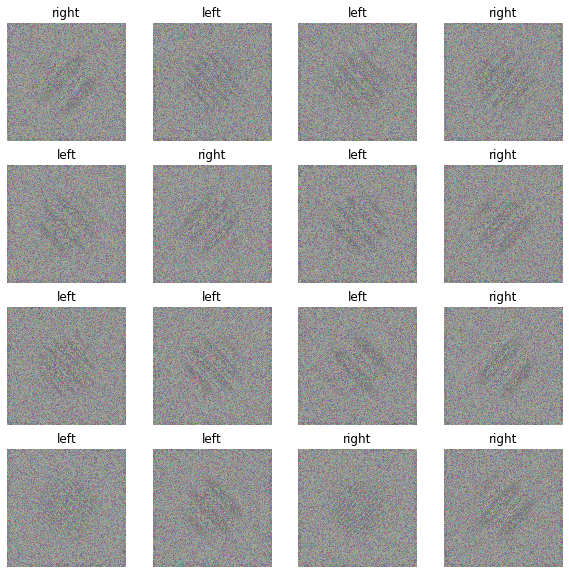

In [19]:

process_function = partial(process_func_visualization,
                           noise_level = .5, # <- change this
                           brightness_level = .3, # <- change this
                           )
gen             = ImageDataGenerator(preprocessing_function = process_function, )
data_gen        = gen.flow_from_directory(os.path.join(working_dir,'validation'),
                                            target_size       = (image_resize,image_resize),  # resize the image
                                            batch_size        = batch_size,                   # batch size
                                            class_mode        = class_mode,                   # get the labels from the folders
                                            shuffle           = True,                        # shuffle for different epochs
                                            seed              = 12345,                        # replication purpose
                                            )
X,y = next(data_gen)
fig,axes = plt.subplots(figsize = (10,10),nrows = 4,ncols = 4)
for ax,X_,y_ in zip(axes.flatten(),X,y):
    ax.imshow(X_ / 255.)
    ax.set(xticks=[],yticks=[],title = {0:'left',1:'right'}[y_[1]])
    ax.axis('off')

## who wants to write the code for [Bayesian optimization](https://scikit-optimize.github.io/)?

In [0]:
#!pip install scikit-optimize

In [21]:
import skopt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## The problem now becomes: 

1. how to define the objective function to reflect how the experimental stimuli influence the predictions of the stimuli
2. how to measure the predictions -- loss functions

Each of these requires more heuristic tuning

In [0]:
from skopt import forest_minimize,callbacks
from skopt.space import Real
from skopt.utils import use_named_args
def cross_entropy(p, q):
	return -np.mean([p[i]*np.log2(q[i]) for i in range(len(p))])
def compute_kl_divergence(p_probs, q_probs):
    """"KL (p || q)"""
    kl_div = p_probs * np.log(p_probs / q_probs)
    return -np.sum(kl_div)
from sklearn import metrics

In [23]:
space = [Real(0,noise_upper,prior='uniform',name = 'noise_level'),
         Real(bright_lower,1.,prior='uniform',name = 'brightness_level')]
@use_named_args(space)
def objective(**params):
    rho = .25 # <- hard to determine, consider this a hyper-hyperparameter
    y_pred,y_true = experiment(**params)
    accuracy = cross_entropy(y_true,y_pred[:,-1])
    confidence = compute_kl_divergence(np.ones(y_pred.shape[0]) * .5,  y_pred.max(1))
    return rho * accuracy + (1 - rho) * confidence
rho = .25
y_pred,y_true = experiment(**{'noise_level':.7,'brightness_level':.5})
accuracy = cross_entropy(y_true,y_pred[:,-1])
confidence = compute_kl_divergence(np.ones(y_pred.shape[0]) * .5,  y_pred.max(1))
print(y_pred.max(1),accuracy,confidence,rho * accuracy + (1 - rho) * confidence)

Found 40 images belonging to 2 classes.
[0.942289   0.8788552  0.6411307  0.9224746  0.91539586 0.7034813
 0.8361759  0.764861   0.93222725 0.88224995 0.6865882  0.78084636
 0.85540056 0.79720175 0.7596846  0.836893   0.7715967  0.90107894
 0.7787958  0.69275546 0.9163566  0.7195592  0.87157476 0.7464068
 0.9131     0.90088713 0.92284405 0.73486966 0.9311507  0.8687724
 0.8926467  0.766774   0.90189624 0.64579976 0.74056774 0.7079732
 0.7447734  0.5213853  0.8365537  0.6655897  0.9124523  0.8333474
 0.7367377  0.8244857  0.94347817 0.82007134 0.8865398  0.8471373
 0.8665645  0.8382961  0.71585053 0.7626583  0.7658666  0.5998031
 0.7544373  0.87945926 0.70890653 0.63315594 0.76652294 0.8343605
 0.80613405 0.8733167  0.8058184  0.8243583  0.80383307 0.7913203
 0.8711263  0.8812285  0.9684175  0.82584596 0.8810311  0.8379848
 0.887879   0.89738375 0.77281445 0.8451677  0.8613985  0.784037
 0.904743   0.9089568 ] 1.3497263818979264 19.27783432496441 14.795807339197788


In [24]:
res_gp = forest_minimize(objective, space, n_calls=int(50), random_state=12345,acq_func = 'EI',
                     callback = callbacks.DeltaYStopper(delta=1e-3),
                     kappa = 1e12,verbose = 0,)

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


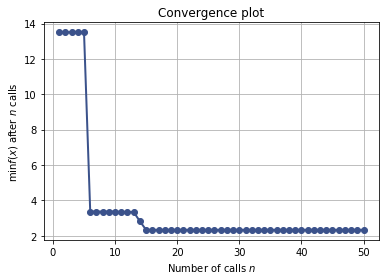

In [25]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

In [26]:
experiment(*res_gp.x_iters[res_gp.func_vals.argmin()]),res_gp.x_iters[res_gp.func_vals.argmin()]

Found 40 images belonging to 2 classes.


((array([[0.510978  , 0.489022  ],
         [0.5232425 , 0.47675753],
         [0.5394103 , 0.46058974],
         [0.5186048 , 0.48139516],
         [0.52967846, 0.47032154],
         [0.5316763 , 0.46832365],
         [0.54477715, 0.45522285],
         [0.5326555 , 0.46734455],
         [0.51974535, 0.48025468],
         [0.52347   , 0.47652996],
         [0.5422235 , 0.4577765 ],
         [0.5255545 , 0.47444552],
         [0.51728255, 0.48271745],
         [0.52548903, 0.47451097],
         [0.53177184, 0.46822822],
         [0.531843  , 0.46815693],
         [0.5311364 , 0.46886364],
         [0.54287165, 0.45712832],
         [0.53666526, 0.46333477],
         [0.57277805, 0.42722198],
         [0.54534805, 0.45465195],
         [0.5640539 , 0.4359461 ],
         [0.5485324 , 0.45146754],
         [0.5270899 , 0.47291008],
         [0.5182847 , 0.48171526],
         [0.5641016 , 0.43589842],
         [0.5610425 , 0.4389575 ],
         [0.535265  , 0.46473503],
         [0.5690102 

## Eventually, we reach to a state where the noise is high and lumimum is low, thus, the confidence of the prediction is about 0.5, but we kinda achieve above chance accuracy. 

In [27]:
noise_level,brightness_level = res_gp.x_iters[res_gp.func_vals.argmin()]
process_function = partial(process_func_visualization,noise_level = noise_level, brightness_level = brightness_level)
y_pred,y_true = experiment(noise_level = noise_level, brightness_level = brightness_level,process_function = partial(process_func,noise_level = noise_level, brightness_level = brightness_level))
gen             = ImageDataGenerator(
                                        preprocessing_function = process_function, 
                                        )
data_gen        = gen.flow_from_directory(os.path.join(working_dir,'validation'),
                                            target_size       = (image_resize,image_resize),  # resize the image
                                            batch_size        = batch_size,                   # batch size
                                            class_mode        = class_mode,                   # get the labels from the folders
                                            shuffle           = True,                        # shuffle for different epochs
                                            seed              = 12345,                        # replication purpose
                                            )
X,y = next(data_gen)

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Text(0.5, 0.98, 'score = 0.3681, noise level = 0.5556, brightness = 0.0007')

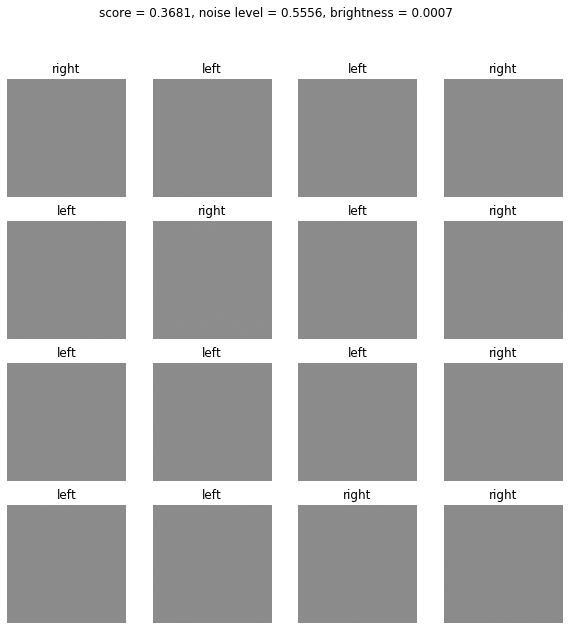

In [28]:
fig,axes = plt.subplots(figsize = (10,10),nrows = 4,ncols = 4)
for ax,X_,y_ in zip(axes.flatten(),X,y):
    ax.imshow(X_ / 255.)
    ax.set(xticks=[],yticks=[],title = {0:'left',1:'right'}[y_[1]])
    ax.axis('off')
score = metrics.roc_auc_score(y_true,y_pred[:,-1])
confidence = y_pred.max(1)
titls = f"score = {score:.4f}, noise level = {noise_level:.4f}, brightness = {brightness_level:.4f}"
_=fig.suptitle(titls)

[Text(0.5, 1.0, 'distribution of confidence')]

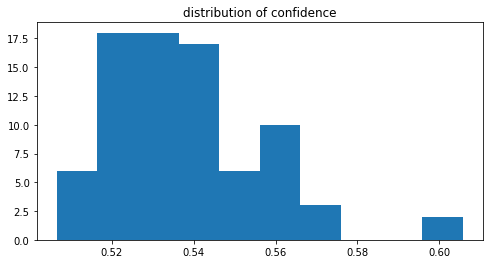

In [29]:
fig,ax = plt.subplots(figsize = (8,4))
_ = ax.hist(confidence)
ax.set(title = 'distribution of confidence')